In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

- https://www.kaggle.com/msripooja/dog-images-classification-using-keras-alexnet
- https://www.kaggle.com/jessicali9530/stanford-dogs-dataset

## Load data

In [2]:
fpath = "data/images/Images/"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['n02097658-silky_terrier', 'n02092002-Scottish_deerhound', 'n02099849-Chesapeake_Bay_retriever', 'n02091244-Ibizan_hound', 'n02095314-wire-haired_fox_terrier', 'n02091831-Saluki', 'n02102318-cocker_spaniel', 'n02104365-schipperke', 'n02090622-borzoi', 'n02113023-Pembroke', 'n02105505-komondor', 'n02093256-Staffordshire_bullterrier', 'n02113799-standard_poodle', 'n02109961-Eskimo_dog', 'n02089973-English_foxhound', 'n02099601-golden_retriever', 'n02095889-Sealyham_terrier', 'n02085782-Japanese_spaniel', 'n02097047-miniature_schnauzer', 'n02110063-malamute'] 

No. of categories =  20


### Load data into lists

In [22]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name,0)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((232, 232))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  3416 
No. of labels loaded =  3416
<class 'list'> <class 'list'>


In [23]:
# Convert to arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (3416, 232, 232, 3) 
Labels shape =  (3416,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


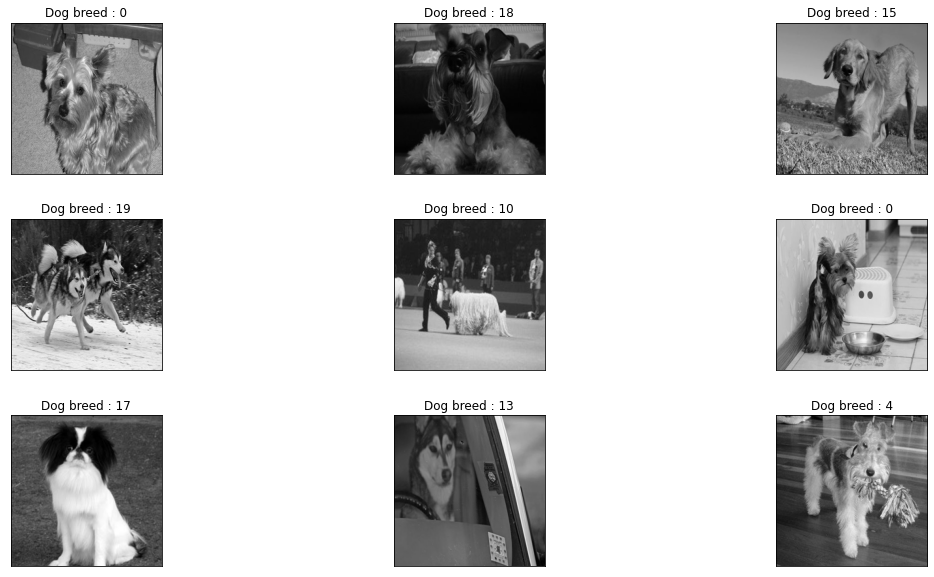

In [24]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Dog breed : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

### Prepare data for Autoencoder

In [25]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 3413 3414 3415]

'n' values after shuffling =  [1963 1791  170 ... 1294  860 3174]


In [26]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (3416, 232, 232, 3) 
Labels shape after shuffling =  (3416,)


In [27]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (3416, 232, 232, 3)


### Split Data

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (2732, 232, 232, 3)
y_train shape =  (2732,)

x_test shape =  (684, 232, 232, 3)
y_test shape =  (684,)


# Convolutional Autoencoder

In [29]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [30]:
#Create Model

input_img = Input(shape=(232, 232,3))

encoded = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2,2), padding='same')(encoded)
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded)
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded)

decoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(8, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(16, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2,2))(decoded)

decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

In [31]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 232, 232, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 232, 232, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 116, 116, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 8)        

In [32]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [33]:
x_train.shape

(2732, 232, 232, 3)

In [34]:
x_train = x_train.reshape((x_train.shape[0],232,232,3))

In [ ]:
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

log_dir = os.path.join('logs','conv_autoencoder_bw')
tensorboard = TensorBoard(log_dir=log_dir)

autoencoder.fit(x_train, x_train,
               epochs=10000,
               batch_size=64,
               shuffle=True,
               validation_split=0.2,
               callbacks=([stop,tensorboard]))

Epoch 1/10000
 1/35 [..............................] - ETA: 0s - loss: 0.6934WARNING:tensorflow:From /Users/ashleyadrias/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
35/35 [==============================] - 95s 3s/step - loss: 0.6603 - val_loss: 0.5961
Epoch 2/10000
35/35 [==============================] - 338s 10s/step - loss: 0.5887 - val_loss: 0.5807
Epoch 3/10000
35/35 [==============================] - 227s 6s/step - loss: 0.5791 - val_loss: 0.5779
Epoch 4/10000
35/35 [==============================] - 230s 7s/step - loss: 0.5761 - val_loss: 0.5718
Epoch 5/10000
35/35 [==============================] - 244s 7s/step - loss: 0.5740 - val_loss: 0.5697
Epoch 6/10000
35/35 [==============================] - 313s 9s/step - loss: 0.5727 - val_loss: 0.5697
Epoch 7/10000
35/35 [===

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [74]:
decoded_imgs = autoencoder.predict(x_test)

In [75]:
decoded_imgs.shape

(684, 232, 232, 3)

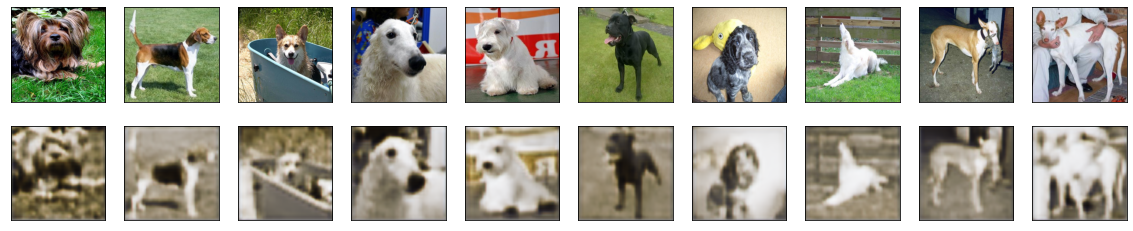

In [81]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(232,232,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(232,232,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Information Retrieval

In [82]:
encoder = Model(input_img,encoded)

In [83]:
x_compressed = encoder.predict(x_train)

In [84]:
x_compressed.shape

(2732, 29, 29, 8)

In [93]:
x_compressed= x_compressed.reshape((x_compressed.shape[0],6728)) # 29*29*8 = 6728

In [111]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
nn.fit(x_compressed)

NearestNeighbors(algorithm='ball_tree', n_neighbors=10)

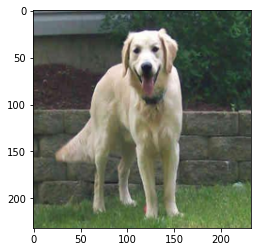

In [187]:
plt.imshow(x_train[23])

In [188]:
y_train[23]

15

In [189]:
x = x_train[23]
x.shape

(232, 232, 3)

In [190]:
x = np.expand_dims(x, axis=0)
x.shape

(1, 232, 232, 3)

In [191]:
x = np.expand_dims(x, axis=-1)
x.shape

(1, 232, 232, 3, 1)

In [192]:
pred = encoder.predict(x)
pred.shape

(1, 29, 29, 8)

In [194]:
preds = nn.kneighbors(pred.reshape(1,6728))[1]
preds

array([[  23, 1073,  115, 2459,   15, 1027, 2004, 1069, 1443,  185]])

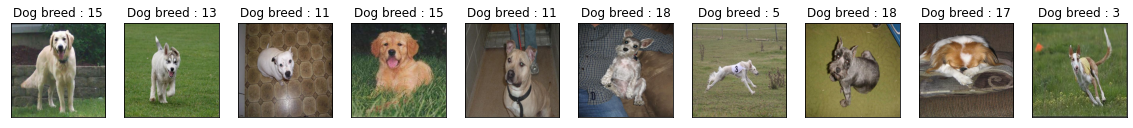

In [139]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.title('Dog breed : {}'.format(y_train[preds[0,i]]))
    plt.imshow(x_train[preds[0,i]])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [143]:
categories[11]

'n02093256-Staffordshire_bullterrier'

## TEST with HUMANS

In [146]:
# maxime = cv2.imread('data/max.png')
# maxime = cv2.cvtColor(maxime, cv2.COLOR_BGR2RGB)
# maxime_array = Image.fromarray(maxime, 'RGB')
            
# #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
# resized_max = maxime_array.resize((232, 232))

In [327]:
img = cv2.imread('data/husky4.jpg',0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
img_array = Image.fromarray(img, 'RGB')
            
#resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
resized_img = img_array.resize((232, 232))

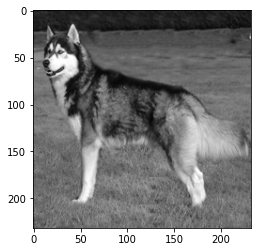

In [328]:
plt.imshow(resized_img)

In [329]:
resized_img_array = np.array(resized_img)/255.

In [330]:
resized_img_array.shape

(232, 232, 3)

In [331]:
x = np.expand_dims(resized_img_array, axis=0)
x.shape

(1, 232, 232, 3)

In [332]:
x = np.expand_dims(x, axis=-1)
x.shape

(1, 232, 232, 3, 1)

In [333]:
pred = encoder.predict(x)
pred.shape

(1, 29, 29, 8)

In [334]:
preds = nn.kneighbors(pred.reshape(1,6728))[1]

In [335]:
preds

array([[ 383, 2379,  669,   15,  480, 2381, 1755, 1197, 1204, 1629]])

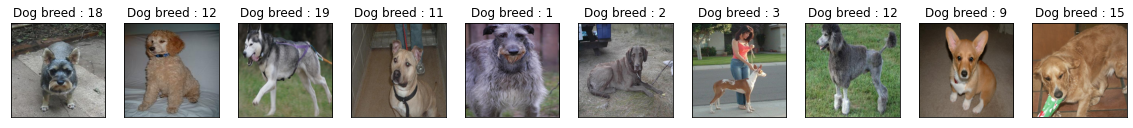

In [336]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.title('Dog breed : {}'.format(y_train[preds[0,i]]))
    plt.imshow(x_train[preds[0,i]])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

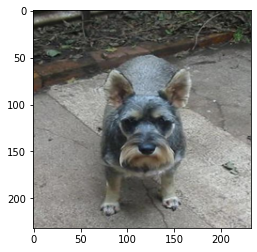

In [338]:
plt.imshow(x_train[383])

In [339]:
categories[18]

'n02097047-miniature_schnauzer'